# This is toy experiment which demo how to get the data and use a simplified unet to train and test 

### install libraries if not already present. 
### You can create a suitable anaconda environment for gpu and tensorflow with the code below in a terminal 
### conda create --name environment_name tensorflow-gpu

### You can install import libraries needed
##### !pip install numpy==1.23.4
##### !pip install pandas
##### !pip install scikit-learn
##### !pip install keras==2.6
##### !pip install opencv-python 
##### !pip install matplotlib
##### !pip install tensorflow==2.6.0
##### !pip install focal-loss
##### !pip install tf-compactprogbar

### check if you have gpu

In [1]:
import tensorflow as tf
for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9



### import libraries needed

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import tensorflow.keras as keras
from tensorflow.keras.utils import load_img, img_to_array, array_to_img, to_categorical
from tensorflow.keras.preprocessing import image
from focal_loss import SparseCategoricalFocalLoss
from tf_compactprogbar import CompactProgressBar
progBar = CompactProgressBar(notebook=False)


### get function that can extract data from the image and label folder 

In [4]:
from DataOps2 import get_batch_of_image_and_label
#from DataOps import get_train_val_test_data

In [5]:
img_length = 512
img_breadth = 256
input_path =  'val_address.csv'
target_path =  'val_address.csv'
input_filter_type =".jpg"
target_filter_type =".png"


val_start   = 0
val_end     = 100
test_start  = 100
test_end    = 200

## get val data

In [6]:
[val_input_imgs, val_targets] = get_batch_of_image_and_label(input_path = input_path, 
                             target_path = target_path, 
                             input_filter_type = input_filter_type, 
                             target_filter_type = target_filter_type,
                             img_length = img_length, 
                             img_breadth = img_breadth, 
                             chunkstart = val_start, 
                             chunkend = val_end, 
                             seed = 123, 
                             shuffle = True,
                             labelA = [210, 60, 60], 
                             labelB = [250, 170, 35])

## get test data

In [7]:
[test_input_imgs, test_targets] = get_batch_of_image_and_label(input_path = input_path, 
                             target_path = target_path, 
                             input_filter_type = input_filter_type, 
                             target_filter_type = target_filter_type,
                             img_length = img_length, 
                             img_breadth = img_breadth, 
                             chunkstart = test_start, 
                             chunkend = test_end, 
                             seed = 123, 
                             shuffle = True, 
                             labelA = [210, 60, 60], 
                             labelB = [250, 170, 35])

### define model

In [8]:

def encoder_block (x_input, number_of_filters):
    encoded = keras.layers.Conv2D(number_of_filters, (3,3), padding = 'same', activation = 'relu')(x_input)
    encoded = keras.layers.Conv2D(number_of_filters, (3,3), padding = 'same', activation = 'relu')(encoded)
    output = keras.layers.MaxPooling2D((2,2))(encoded)
    return [encoded, output]

def decoder_block (encoded, x_input, number_of_filters):
    x_input = keras.layers.Conv2DTranspose(number_of_filters, (2, 2), strides=(2, 2), padding="valid", activation=None)(x_input)
    x_input = keras.layers.Concatenate()([x_input, encoded])
    x_input = keras.layers.Conv2D(number_of_filters, (3,3), padding='same', activation='relu')(x_input)
    x_input = keras.layers.Conv2D(number_of_filters, (3,3), padding='same', activation='relu')(x_input)
    return x_input

def c_unet_1(img_breadth, img_length, number_of_class,  unit_channel):
    inputs = keras.Input(shape = (img_breadth, img_length, 3))
    x = keras.layers.Rescaling(1/255)(inputs)

    # encoder layers
    [y1, x] = encoder_block(x,  1 * unit_channel)
    [y2, x] = encoder_block(x,  2 * unit_channel)
    [y3, x] = encoder_block(x,  4 * unit_channel)
    [y4, x] = encoder_block(x,  8 * unit_channel)

    x = keras.layers.Conv2D( 16 * unit_channel, (3,3), padding='same', activation='relu')(x)
    x = keras.layers.Conv2D( 16 * unit_channel, (3,3), padding='same', activation='relu')(x)

    # decoder layers
    x = decoder_block (y4, x,  8 * unit_channel)
    x = decoder_block (y3, x,  4 * unit_channel)
    x = decoder_block (y2, x,  2 * unit_channel)
    x = decoder_block (y1, x,  1 * unit_channel)

    x = keras.layers.Conv2D(number_of_class, (3,3), activation = 'softmax', padding = 'same')(x)
    model = keras.Model(inputs, x)
    return model
    
    

In [9]:
number_of_class = 2
unit_channel = 32
model = c_unet_1(img_breadth, img_length, number_of_class, unit_channel)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 512, 32) 896         rescaling[0][0]                  
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 512, 32) 9248        conv2d[0][0]                     
______________________________________________________________________________________________

In [10]:
name_of_model_file = "model1.keras"

In [11]:

###### k_loss = SparseCategoricalFocalLoss(gamma=2)
##### k_loss = 'sparse_categorical_crossentropy'

class_weight_list=[1, 10]

k_loss = SparseCategoricalFocalLoss(gamma=2, class_weight=class_weight_list)

model.compile(loss = k_loss, 
              optimizer = 'adam')

callbacks = [
    keras.callbacks.ModelCheckpoint(name_of_model_file, 
    save_best_only = True),
    progBar
]

### first load model if already available


In [12]:
import os 
  
path = name_of_model_file
isExist = os.path.exists(path) 
if(isExist):
    model = keras.models.load_model(name_of_model_file)
else:
    print("model not yet available")

model not yet available


### break the data into chunks before training with gpu because of gpu's memory limitation

In [13]:
import gc
outer_batch_size = 256
train_start  = 0
train_end   = 1500 
train_input_path = 'train_address.csv'
train_target_path = 'train_address.csv'

def phase_train():
    for i in range (train_start, train_end, outer_batch_size):
        gc.collect()
        
        [x, y] = get_batch_of_image_and_label(input_path = train_input_path, 
                             target_path = train_target_path, 
                             input_filter_type = input_filter_type, 
                             target_filter_type = target_filter_type,
                             img_length = img_length, 
                             img_breadth = img_breadth, 
                             chunkstart = i, 
                             chunkend = i + outer_batch_size, 
                             seed = 123, 
                             shuffle = False,
                             labelA = [210, 60, 60], 
                             labelB = [250, 170, 35])

        
        history = model.fit(x, y,
                    epochs = 10,
                    callbacks = callbacks,
                    batch_size = 2,
                    validation_data=(val_input_imgs, val_targets),
                    verbose=0)


In [14]:
phase_train()

[Training]: 100%|███| 10/10 [02:00<00:00, 12.01s/it, loss=0.37, val_loss=0.317, best_loss=0.0883, best_val_loss=0.0501]


### make prediction

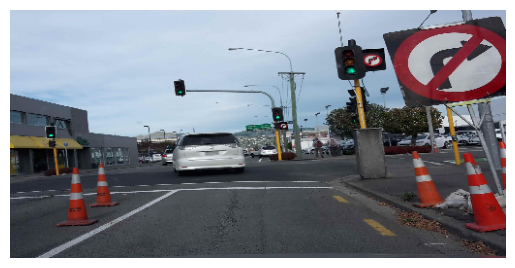

In [15]:
i=8
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

In [16]:
model = keras.models.load_model(name_of_model_file)
mask = model.predict(np.expand_dims(test_image, 0))[0]

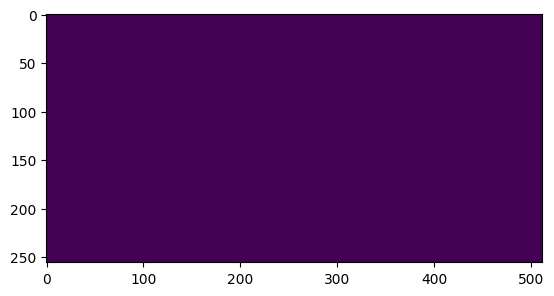

In [17]:
def display_predicted_mask(mask):
    mask = np.argmax(mask, axis=-1)
    plt.imshow(mask)

display_predicted_mask(mask)

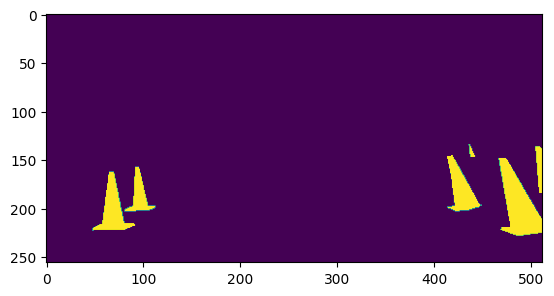

In [18]:
plt.imshow(val_targets[i])

### ******************************************************************************** ####

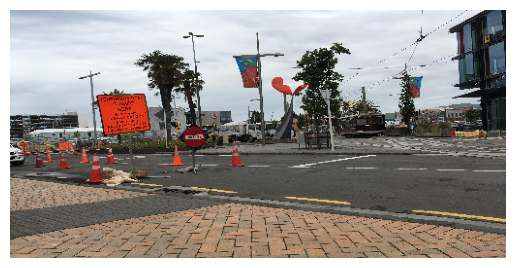

In [19]:
i=3
test_image = test_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

In [20]:
model = keras.models.load_model(name_of_model_file)
mask = model.predict(np.expand_dims(test_image, 0))[0]

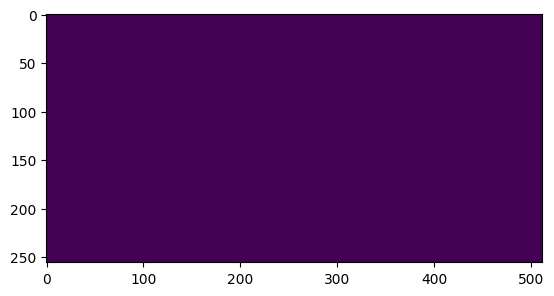

In [21]:
def display_predicted_mask(mask):
    mask = np.argmax(mask, axis=-1)
    plt.imshow(mask)

display_predicted_mask(mask)

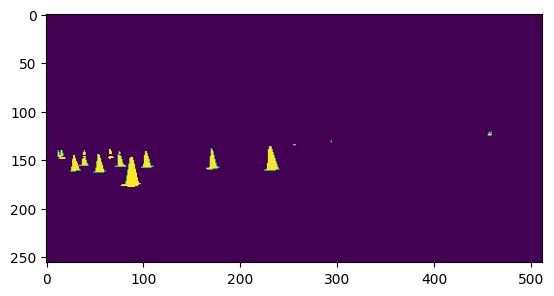

In [22]:
plt.imshow(test_targets[i])

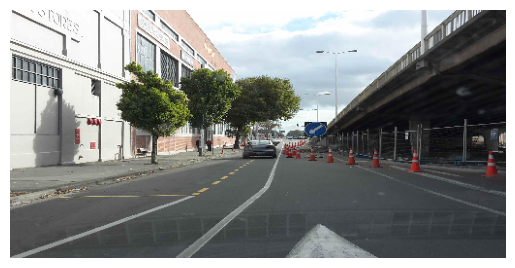

In [23]:
i=5
test_image = test_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

In [24]:
model = keras.models.load_model(name_of_model_file)
mask = model.predict(np.expand_dims(test_image, 0))[0]

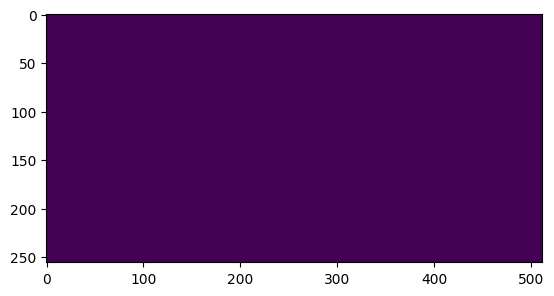

In [25]:
def display_predicted_mask(mask):
    mask = np.argmax(mask, axis=-1)
    plt.imshow(mask)

display_predicted_mask(mask)

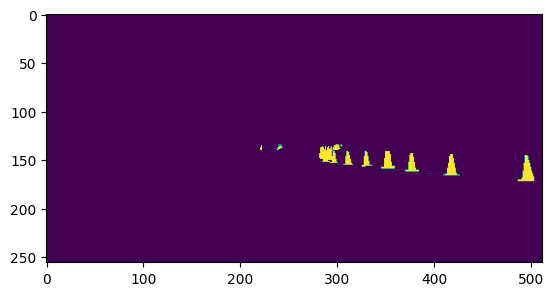

In [26]:
plt.imshow(test_targets[i])